<a href="https://colab.research.google.com/github/Namratha0506/CHORNIC-KIDNEY-DISEASES-PROJECT-/blob/main/kidneychronicfinalcode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Conv2D, BatchNormalization, ReLU, Add, GlobalAveragePooling2D
from tensorflow.keras.applications import DenseNet121, ResNet50
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf


# LOAD AND PREPROCESSING CKD DATASET

In [2]:
# Load the dataset
CKD_data = pd.read_csv("/content/Namratha_Kidney_disease_Dataset.csv")  # Replace with your dataset path

# Display dataset information
print("Dataset Info:")
print(CKD_data.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     391 non-null    float64
 1   bp      388 non-null    float64
 2   sg      353 non-null    float64
 3   al      354 non-null    float64
 4   su      351 non-null    float64
 5   rbc     248 non-null    object 
 6   pc      335 non-null    object 
 7   pcc     396 non-null    object 
 8   ba      396 non-null    object 
 9   bgr     356 non-null    float64
 10  bu      381 non-null    float64
 11  sc      383 non-null    float64
 12  sod     313 non-null    float64
 13  pot     312 non-null    float64
 14  hemo    348 non-null    float64
 15  pcv     329 non-null    float64
 16  wbcc    294 non-null    float64
 17  rbcc    269 non-null    float64
 18  htn     398 non-null    object 
 19  dm      398 non-null    object 
 20  cad     398 non-null    object 
 21  appet   399 non-null    o

In [3]:
# Check unique values in 'class' column
print("Unique values in 'class':", CKD_data['class'].unique())

# Standardize class values: lowercase and strip whitespace
CKD_data['class'] = CKD_data['class'].str.strip().str.lower()

# Map 'ckd' to 0 and 'notckd' to 1
CKD_data['class'] = CKD_data['class'].map({'ckd': 0, 'notckd': 1})

Unique values in 'class': ['ckd' 'ckd\t' 'notckd']


In [4]:
# Check for NaN after mapping
if CKD_data['class'].isnull().any():
    print("\nRows with NaN in 'class' column after mapping:")
    print(CKD_data[CKD_data['class'].isnull()])

    # Handle NaN values (optional: drop or replace)
    # Example: Replace NaN with the most frequent class (0 or 1)
    most_frequent_class = CKD_data['class'].mode()[0]
    CKD_data['class'].fillna(most_frequent_class, inplace=True)

In [5]:
 CKD_data['class']

,class
0,0
1,0
2,0
3,0
4,0
...,...
395,1
396,1
397,1
398,1


In [8]:
# categorical_cols = ['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane', 'class']
categorical_cols = ['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane']
label_encoder = LabelEncoder()

for col in categorical_cols:
    CKD_data[col] = label_encoder.fit_transform(CKD_data[col])


In [9]:
CKD_data

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,2,1,0,0,121.0,...,44.0,7800.0,5.2,1,2,0,0,0,0,0
1,7.0,50.0,1.020,4.0,0.0,2,1,0,0,NaN,...,38.0,6000.0,NaN,0,1,0,0,0,0,0
2,62.0,80.0,1.010,2.0,3.0,1,1,0,0,423.0,...,31.0,7500.0,NaN,0,2,0,1,0,1,0
3,48.0,70.0,1.005,4.0,0.0,1,0,1,0,117.0,...,32.0,6700.0,3.9,1,1,0,1,1,1,0
4,51.0,80.0,1.010,2.0,0.0,1,1,0,0,106.0,...,35.0,7300.0,4.6,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,55.0,80.0,1.020,0.0,0.0,1,1,0,0,140.0,...,47.0,6700.0,4.9,0,1,0,0,0,0,1
396,42.0,70.0,1.025,0.0,0.0,1,1,0,0,75.0,...,54.0,7800.0,6.2,0,1,0,0,0,0,1
397,12.0,80.0,1.020,0.0,0.0,1,1,0,0,100.0,...,49.0,6600.0,5.4,0,1,0,0,0,0,1
398,17.0,60.0,1.025,0.0,0.0,1,1,0,0,114.0,...,51.0,7200.0,5.9,0,1,0,0,0,0,1


In [10]:
CKD_data.fillna(CKD_data.mean(), inplace=True)


In [11]:
CKD_data

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,2,1,0,0,121.000000,...,44.0,7800.0,5.200000,1,2,0,0,0,0,0
1,7.0,50.0,1.020,4.0,0.0,2,1,0,0,148.036517,...,38.0,6000.0,4.707435,0,1,0,0,0,0,0
2,62.0,80.0,1.010,2.0,3.0,1,1,0,0,423.000000,...,31.0,7500.0,4.707435,0,2,0,1,0,1,0
3,48.0,70.0,1.005,4.0,0.0,1,0,1,0,117.000000,...,32.0,6700.0,3.900000,1,1,0,1,1,1,0
4,51.0,80.0,1.010,2.0,0.0,1,1,0,0,106.000000,...,35.0,7300.0,4.600000,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,55.0,80.0,1.020,0.0,0.0,1,1,0,0,140.000000,...,47.0,6700.0,4.900000,0,1,0,0,0,0,1
396,42.0,70.0,1.025,0.0,0.0,1,1,0,0,75.000000,...,54.0,7800.0,6.200000,0,1,0,0,0,0,1
397,12.0,80.0,1.020,0.0,0.0,1,1,0,0,100.000000,...,49.0,6600.0,5.400000,0,1,0,0,0,0,1
398,17.0,60.0,1.025,0.0,0.0,1,1,0,0,114.000000,...,51.0,7200.0,5.900000,0,1,0,0,0,0,1


In [12]:
CKD_data['rbc']

,rbc
0,2
1,2
2,1
3,1
4,1
...,...
395,1
396,1
397,1
398,1


In [13]:
# Check for missing values in the dataset
missing_values = CKD_data.isnull().sum()

In [14]:
missing_values

,0
age,0
bp,0
sg,0
al,0
su,0
rbc,0
pc,0
pcc,0
ba,0
bgr,0


In [15]:
# Display columns with missing values and their counts
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
age      0
bp       0
sg       0
al       0
su       0
rbc      0
pc       0
pcc      0
ba       0
bgr      0
bu       0
sc       0
sod      0
pot      0
hemo     0
pcv      0
wbcc     0
rbcc     0
htn      0
dm       0
cad      0
appet    0
pe       0
ane      0
class    0
dtype: int64


In [16]:
# Optionally, display only columns with missing values
print("\nColumns with missing values:")
print(missing_values[missing_values > 0])


Columns with missing values:
Series([], dtype: int64)


In [17]:
X_input = CKD_data.drop('class', axis=1)  # Features
y_target = CKD_data['class']  # Target


In [18]:
y_target

,class
0,0
1,0
2,0
3,0
4,0
...,...
395,1
396,1
397,1
398,1


In [19]:
X_input

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,hemo,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane
0,48.0,80.0,1.020,1.0,0.0,2,1,0,0,121.000000,...,15.4,44.0,7800.0,5.200000,1,2,0,0,0,0
1,7.0,50.0,1.020,4.0,0.0,2,1,0,0,148.036517,...,11.3,38.0,6000.0,4.707435,0,1,0,0,0,0
2,62.0,80.0,1.010,2.0,3.0,1,1,0,0,423.000000,...,9.6,31.0,7500.0,4.707435,0,2,0,1,0,1
3,48.0,70.0,1.005,4.0,0.0,1,0,1,0,117.000000,...,11.2,32.0,6700.0,3.900000,1,1,0,1,1,1
4,51.0,80.0,1.010,2.0,0.0,1,1,0,0,106.000000,...,11.6,35.0,7300.0,4.600000,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,55.0,80.0,1.020,0.0,0.0,1,1,0,0,140.000000,...,15.7,47.0,6700.0,4.900000,0,1,0,0,0,0
396,42.0,70.0,1.025,0.0,0.0,1,1,0,0,75.000000,...,16.5,54.0,7800.0,6.200000,0,1,0,0,0,0
397,12.0,80.0,1.020,0.0,0.0,1,1,0,0,100.000000,...,15.8,49.0,6600.0,5.400000,0,1,0,0,0,0
398,17.0,60.0,1.025,0.0,0.0,1,1,0,0,114.000000,...,14.2,51.0,7200.0,5.900000,0,1,0,0,0,0


In [20]:
y_target

,class
0,0
1,0
2,0
3,0
4,0
...,...
395,1
396,1
397,1
398,1


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_input, y_target, test_size=0.2, random_state=42, stratify=y_target)


In [22]:
X_train

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,hemo,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane
380,59.0,60.0,1.020,0.0,0.000000,1,1,0,0,113.000000,...,15.300000,54.000000,6500.000000,4.900000,0,1,0,0,0,0
56,76.0,70.0,1.015,3.0,4.000000,1,0,1,0,148.036517,...,10.200000,30.000000,11300.000000,3.400000,1,2,1,1,1,0
126,70.0,90.0,1.015,0.0,0.000000,2,1,0,0,144.000000,...,12.000000,37.000000,8200.000000,4.500000,1,2,0,1,1,0
371,28.0,60.0,1.025,0.0,0.000000,1,1,0,0,79.000000,...,17.600000,51.000000,6500.000000,5.000000,0,1,0,0,0,0
333,23.0,80.0,1.020,0.0,0.000000,1,1,0,0,99.000000,...,17.700000,46.000000,4300.000000,5.500000,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,56.0,90.0,1.005,4.0,3.000000,0,0,0,0,242.000000,...,8.400000,26.000000,8406.122449,3.000000,1,2,0,1,1,1
274,19.0,80.0,1.020,0.0,0.000000,1,1,0,0,107.000000,...,14.400000,44.000000,8406.122449,4.707435,0,1,0,0,0,0
192,46.0,110.0,1.015,0.0,0.000000,2,1,0,0,130.000000,...,12.526437,38.884498,8406.122449,4.707435,0,1,0,0,0,0
85,70.0,70.0,1.015,2.0,0.450142,2,2,0,0,148.036517,...,9.900000,38.884498,8406.122449,4.707435,0,2,0,1,1,0


In [23]:
X_test

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,hemo,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane
160,81.0,60.0,1.017408,1.016949,0.450142,2,2,0,0,148.0,...,10.9,35.0,9400.0,2.400000,1,2,1,1,1,0
20,61.0,80.0,1.015000,2.000000,0.000000,0,0,0,0,173.0,...,7.7,24.0,9200.0,3.200000,1,2,1,1,1,1
392,57.0,80.0,1.020000,0.000000,0.000000,1,1,0,0,133.0,...,14.8,46.0,6600.0,5.500000,0,1,0,0,0,0
303,55.0,70.0,1.020000,0.000000,0.000000,1,1,0,0,107.0,...,17.0,50.0,6700.0,6.100000,0,1,0,0,0,0
339,25.0,70.0,1.020000,0.000000,0.000000,1,1,0,0,88.0,...,13.3,48.0,7000.0,4.900000,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,45.0,70.0,1.010000,2.000000,0.000000,2,1,0,0,113.0,...,7.9,26.0,5700.0,4.707435,0,1,1,0,0,1
369,75.0,70.0,1.020000,0.000000,0.000000,1,1,0,0,107.0,...,13.6,46.0,10300.0,4.800000,0,1,0,0,0,0
258,42.0,80.0,1.020000,0.000000,0.000000,1,1,0,0,98.0,...,13.9,44.0,8400.0,5.500000,0,1,0,0,0,0
157,62.0,70.0,1.025000,3.000000,0.000000,1,0,0,0,122.0,...,12.6,39.0,7900.0,3.900000,1,2,0,0,0,0


In [24]:
y_test.head()

,class
160,0
20,0
392,1
303,1
339,1


##  SMOTE for handling data imbalance


In [25]:
print("Class distribution before SMOTE:")
print(y_train.value_counts())

Class distribution before SMOTE:
class
0    200
1    120
Name: count, dtype: int64


In [26]:
from imblearn.over_sampling import SMOTE

# Initialize SMOTE with k_neighbors=1
smote = SMOTE(random_state=42, k_neighbors=1)

# Apply SMOTE
X_train, y_train = smote.fit_resample(X_train, y_train)

# Check the class distribution after SMOTE
print("Class distribution after SMOTE:", y_train.value_counts())


Class distribution after SMOTE: class
1    200
0    200
Name: count, dtype: int64


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


# Feature Scaling

In [27]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Model Implementation
## DecisionTreeClassifier

In [28]:
from sklearn.tree import DecisionTreeClassifier


# Initialize a shallow decision tree
dt_model = DecisionTreeClassifier(max_depth=3, random_state=42)

# Train the model
dt_model.fit(X_train, y_train)

# Predict on the test set
y_pred_dt = dt_model.predict(X_test)
y_proba_dt = dt_model.predict_proba(X_test)[:, 1]

# Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt))

# AUC-ROC score
roc_auc_dt = roc_auc_score(y_test, y_proba_dt)
print("AUC-ROC Score:", roc_auc_dt)
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_dt))



Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95        50
           1       1.00      0.83      0.91        30

    accuracy                           0.94        80
   macro avg       0.95      0.92      0.93        80
weighted avg       0.94      0.94      0.94        80

AUC-ROC Score: 0.9053333333333333

Confusion Matrix:
[[50  0]
 [ 5 25]]


In [29]:
# Calculate and print accuracy
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print(f"DecisionTreeClassifier Accuracy: {accuracy_dt * 100:.2f}%")

DecisionTreeClassifier Accuracy: 93.75%


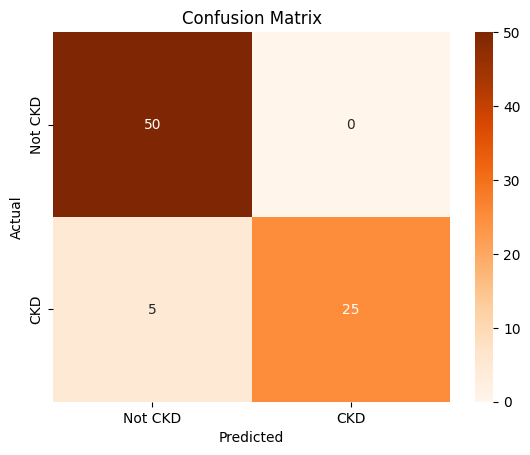

In [30]:
# Confusion matrix
cm_dt = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Oranges', xticklabels=['Not CKD', 'CKD'], yticklabels=['Not CKD', 'CKD'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

## KNeighborsClassification Model

In [31]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, roc_auc_score

# Initialize k-NN with k=3
knn_model = KNeighborsClassifier(n_neighbors=3)

# Train the model
knn_model.fit(X_train, y_train)

# Predict on the test set
y_pred_knn = knn_model.predict(X_test)
y_proba_knn = knn_model.predict_proba(X_test)[:, 1]

# Evaluate the model
print("\nClassification Report:")
print(classification_report(y_test, y_pred_knn))

# AUC-ROC score
roc_auc_knn = roc_auc_score(y_test, y_proba_knn)
print("AUC-ROC Score:", roc_auc_knn)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_knn))



Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97        50
           1       0.97      0.93      0.95        30

    accuracy                           0.96        80
   macro avg       0.96      0.96      0.96        80
weighted avg       0.96      0.96      0.96        80

AUC-ROC Score: 0.956

Confusion Matrix:
[[49  1]
 [ 2 28]]


In [32]:
# Calculate and print accuracy
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f"KNeighborsClassifier Accuracy: {accuracy_knn * 100:.2f}%")

KNeighborsClassifier Accuracy: 96.25%


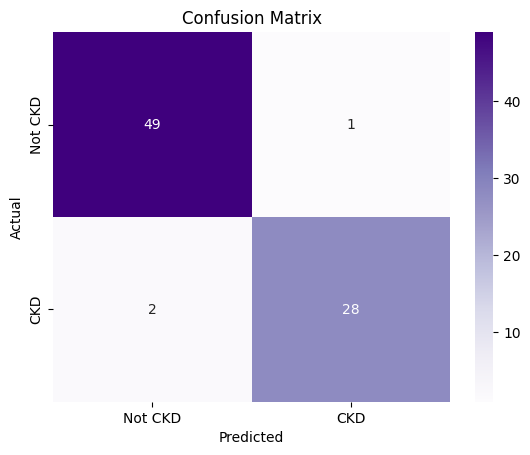

In [33]:
# Confusion matrix
cm_knn = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='Purples', xticklabels=['Not CKD', 'CKD'], yticklabels=['Not CKD', 'CKD'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Model Implementation
## CNN Model

In [34]:
# Define the model architecture
cnn_model = Sequential()
cnn_model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
cnn_model.add(Dropout(0.5))  # Regularization
cnn_model.add(Dense(32, activation='relu'))
cnn_model.add(Dropout(0.5))  # Regularization
cnn_model.add(Dense(1, activation='sigmoid'))  # Binary classification

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [35]:
# Compile the model
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [36]:
# Print the CNN model summary
cnn_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 64)                  │           1,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,713 (14.50 KB)

 Trainable params: 3,713 (14.50 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
# Set up early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [38]:
# Train the model
ckd_cnn = cnn_model.fit(X_train, y_train,
                    validation_split=0.2,
                    epochs=20,
                    batch_size=32)
                    # callbacks=[early_stopping])

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.3982 - loss: 1.0890 - val_accuracy: 0.6875 - val_loss: 0.6356
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5390 - loss: 0.8029 - val_accuracy: 0.8625 - val_loss: 0.5535
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6873 - loss: 0.5956 - val_accuracy: 0.9500 - val_loss: 0.4737
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8177 - loss: 0.4389 - val_accuracy: 0.9375 - val_loss: 0.4154
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8572 - loss: 0.4042 - val_accuracy: 0.9750 - val_loss: 0.3438
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8741 - loss: 0.3656 - val_accuracy: 0.9750 - val_loss: 0.2775
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8977 - loss: 0.3078 - val_accuracy: 0.9750 - val_loss: 0.2206
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9303 - loss: 0.2642 - val_accuracy: 0.9750 - val_loss

In [39]:
# Predict on the test set
y_pred_cnn = (cnn_model.predict(X_test) > 0.5).astype("int32")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [40]:
# Classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred_cnn))



Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97        50
           1       0.97      0.93      0.95        30

    accuracy                           0.96        80
   macro avg       0.96      0.96      0.96        80
weighted avg       0.96      0.96      0.96        80



In [41]:
# AUC-ROC score
roc_auc_cnn = roc_auc_score(y_test, y_pred_cnn)
print("AUC-ROC Score:", roc_auc_cnn)

AUC-ROC Score: 0.9566666666666667


In [42]:
# Evaluate the CNN model
evaluation_cnn = cnn_model.evaluate(X_test, y_test, verbose=0)

# Print accuracy
print(f"CNN Test Accuracy: {evaluation_cnn[1] * 100:.2f}%")

CNN Test Accuracy: 96.25%


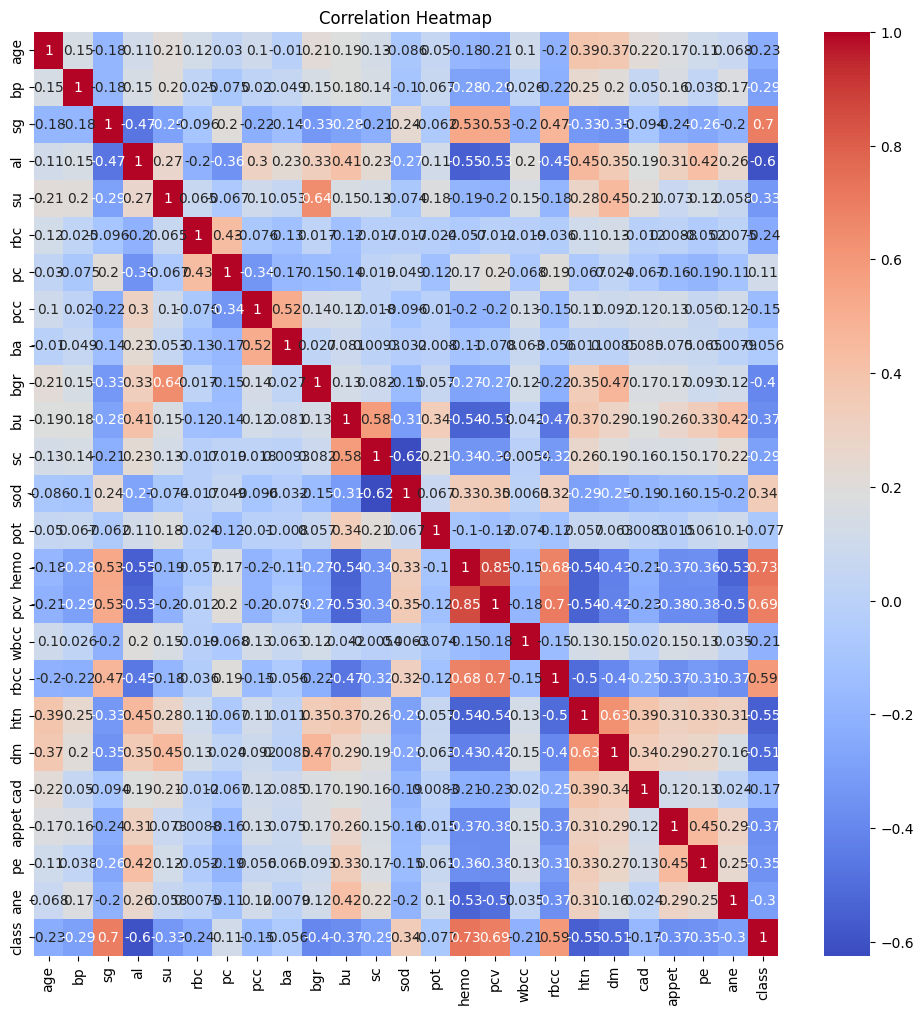

In [43]:
# Correlation matrix to understand relationships between energy metrics
plt.figure(figsize=(12, 12))
sns.heatmap(CKD_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

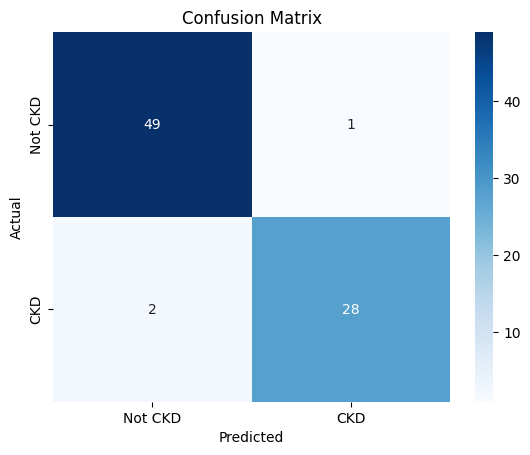

In [44]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_cnn)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not CKD', 'CKD'], yticklabels=['Not CKD', 'CKD'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

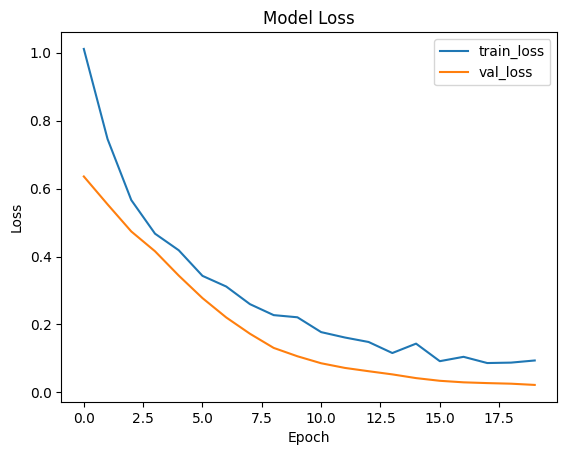

In [45]:
# Plot training history
plt.plot(ckd_cnn.history['loss'], label='train_loss')
plt.plot(ckd_cnn.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

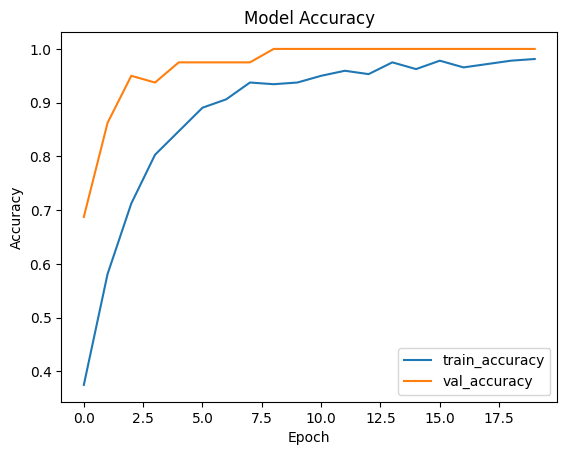

In [46]:
plt.plot(ckd_cnn.history['accuracy'], label='train_accuracy')
plt.plot(ckd_cnn.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## Comparison of three Models

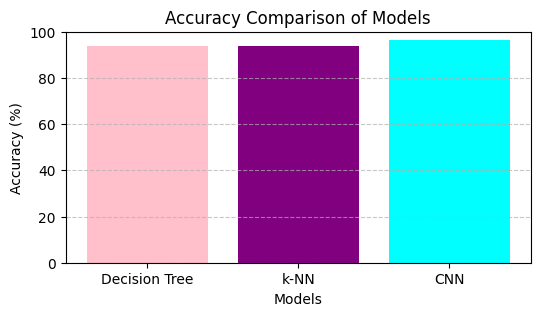

In [47]:
import matplotlib.pyplot as plt

# Accuracy values for each model
model_names = ['Decision Tree', 'k-NN', 'CNN']
accuracies = [accuracy_dt * 100, accuracy_dt * 100, evaluation_cnn[1] * 100]

# Plot accuracy comparison
plt.figure(figsize=(6, 3))
plt.bar(model_names, accuracies, color=['pink', 'purple', 'cyan'])
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Comparison of Models')
plt.ylim(0, 100)  # Ensure y-axis covers 0-100%
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


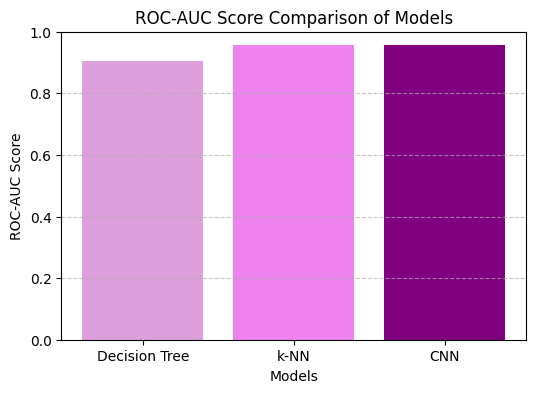

In [48]:

# Example ROC-AUC scores for models (replace with your actual values)
model_names = ['Decision Tree', 'k-NN', 'CNN']
roc_auc_scores = [roc_auc_dt, roc_auc_knn, roc_auc_cnn]  # Replace these with your calculated ROC-AUC scores

# Plot ROC-AUC comparison
plt.figure(figsize=(6, 4))
plt.bar(model_names, roc_auc_scores, color=['plum', 'violet', 'purple'])
plt.xlabel('Models')
plt.ylabel('ROC-AUC Score')
plt.title('ROC-AUC Score Comparison of Models')
plt.ylim(0, 1)  # ROC-AUC scores range from 0 to 1
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


           Model  Accuracy (%)
0  Decision Tree        0.9375
1           k-NN        0.9625
2            CNN        0.9625


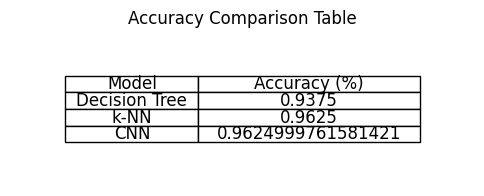

In [49]:
import pandas as pd
import matplotlib.pyplot as plt

# Example accuracy values (replace with your actual calculated accuracies)
model_names = ['Decision Tree', 'k-NN', 'CNN']
accuracies = [accuracy_dt, accuracy_knn, evaluation_cnn[1]]  # Accuracy values in percentages

# Create a DataFrame for comparison
comparison_table = pd.DataFrame({
    'Model': model_names,
    'Accuracy (%)': accuracies
})

# Display the table
print(comparison_table)

# Optionally, display as a nicely formatted table using matplotlib
plt.figure(figsize=(6, 2))
plt.axis('tight')
plt.axis('off')
table = plt.table(cellText=comparison_table.values,
                  colLabels=comparison_table.columns,
                  loc='center',
                  cellLoc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.auto_set_column_width(col=list(range(len(comparison_table.columns))))
plt.title("Accuracy Comparison Table")
plt.show()


Comparison Table:
           Model  Accuracy (%)   AUC-ROC
0  Decision Tree        0.9375  0.905333
1           k-NN        0.9625  0.956000
2            CNN        0.9625  0.956667


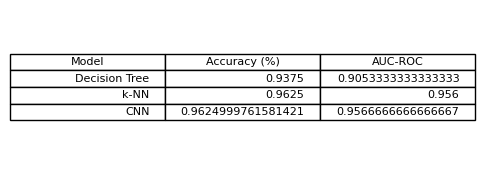

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

# Example data (replace these with your actual calculated values)
model_names = ['Decision Tree', 'k-NN', 'CNN']
accuracies = [accuracy_dt, accuracy_knn, evaluation_cnn[1]]  # Accuracy values in percentages
roc_aucs = [roc_auc_dt, roc_auc_knn, roc_auc_cnn]       # AUC-ROC scores

# Create a DataFrame for comparison
comparison_table = pd.DataFrame({
    'Model': model_names,
    'Accuracy (%)': accuracies,
    'AUC-ROC': roc_aucs
})

# Highlight the table
def highlight_max(s):
    """Highlight the maximum in a Series (row or column)."""
    is_max = s == s.max()
    return ['background-color: lightgreen' if v else '' for v in is_max]

# Style the DataFrame
styled_table = comparison_table.style.apply(highlight_max, subset=['Accuracy (%)', 'AUC-ROC']).set_table_styles(
    [{'selector': 'thead th', 'props': [('background-color', 'lightblue'), ('color', 'black'), ('font-weight', 'bold')]}]
)

# Display the styled table in the notebook or script
print("Comparison Table:")
print(comparison_table)

# Save the styled table as an image (optional, requires matplotlib)
def save_styled_table_as_image(df_styler, filename):
    """Save a styled pandas DataFrame as an image."""
    dfi.export(df_styler, filename)  # You need to install `dfi` for exporting styled tables

# If you're using a script and want a visual representation
plt.figure(figsize=(6, 2))
plt.axis('tight')
plt.axis('off')
table = plt.table(cellText=comparison_table.values,
                  colLabels=comparison_table.columns,
 loc=('center')
)


In [51]:
import plotly.graph_objects as go

# comparison table for the mestrci used in the different models.
EC_data = {
    # 'Model': ['Linear Regression', 'Elastic Net Regression', 'Random Forest'],
    # 'MSE': [mse_lr, mse_en, mse_rf],
    # 'R²': [r2_lr, r2_en, r2_rf],
    # 'RMSE': [rmse_lr, rmse_en, rmse_rf]
    'Model_Names' : ['Decision Tree', 'k-NN', 'CNN'],
    'Accuracies' : [accuracy_dt, accuracy_knn, evaluation_cnn[1]],  # Accuracy values in percentages
    'AUC-ROC' : [roc_auc_dt, roc_auc_knn, roc_auc_cnn]       # AUC-ROC scores

}

# Create a Plotly Table
fig = go.Figure(data=[go.Table(
    header=dict(
        values=["<b>Model_Names</b>", "<b>Accuracies</b>", "<b>AUC-ROC</b>"],
        fill_color="#264653",
        font=dict(color="white", size=14),
        align="center",
    ),
    cells=dict(
        values=[EC_data['Model_Names'], EC_data['Accuracies'], EC_data['AUC-ROC']],
        fill_color=[["#e9f5db"] * len(EC_data['Model_Names']),
                    ["#f6c28b"] * len(EC_data['Accuracies']),
                    ["#d5a6bd"] * len(EC_data['AUC-ROC'])],

        font=dict(color="black", size=12),
        align="center",
    )
)])

# Customize layout
fig.update_layout(
    title="Model Performance Comparison",
    title_font=dict(size=18, family='Arial', color='#DE3163'),
    margin=dict(l=15, r=15, t=50, b=10),
)

# Show the table
fig.show()
